In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.datasets import FunctionDataset, sinusoid
from src.architecture.models import LinearMDN
from src.training import train_loop, mdn_loss, test_loop

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch

In [3]:
TRAIN_SAMPLES = 1000
TEST_SAMPLES = 10000

function_range = (0, 1)

noise_level = 0.03
batch_size = 128
n_epochs = 200

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
sinus_train_dataset = FunctionDataset(
    sinusoid,
    n_samples=TRAIN_SAMPLES,
    range=function_range,
    noise_std=noise_level,
    inverse_function=True,
)

sinus_test_dataset = FunctionDataset(
    sinusoid,
    n_samples=TEST_SAMPLES,
    range=function_range,
    noise_std=0,
    sort=True,
    inverse_function=True,
)

train_dataloader = DataLoader(sinus_train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(sinus_test_dataset, batch_size=batch_size, shuffle=False)

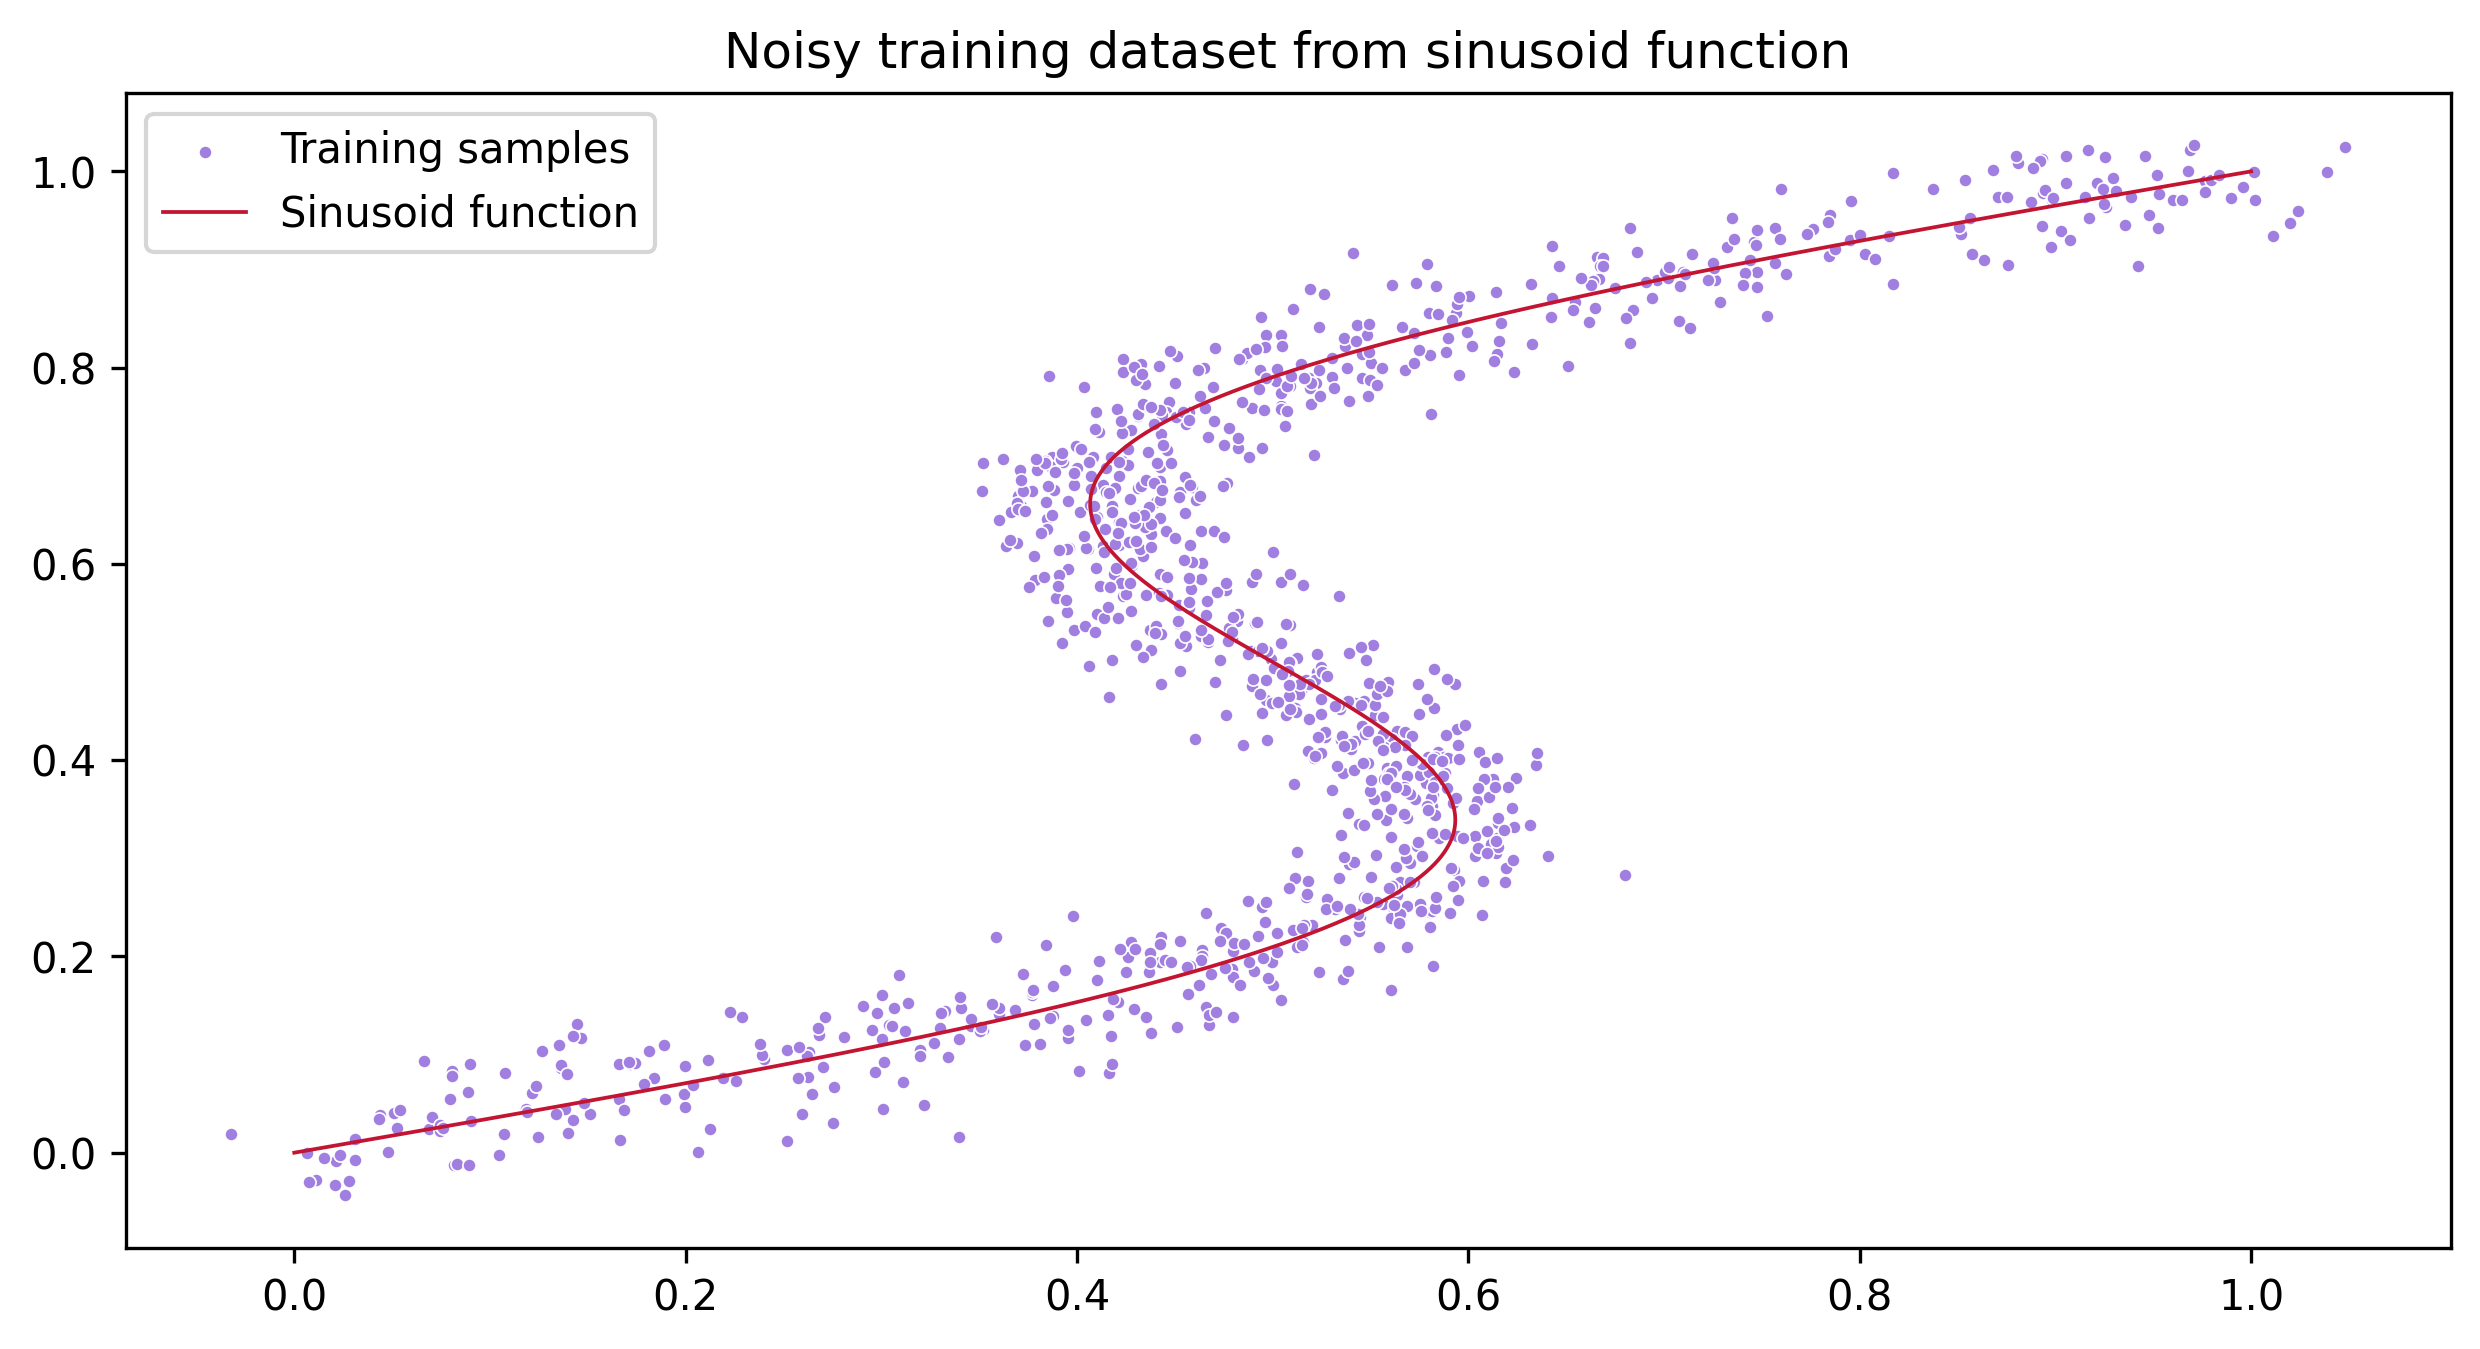

In [5]:
plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(
    sinus_train_dataset.x,
    sinus_train_dataset.y,
    s=10,
    label="Training samples",
    edgecolors="white",
    color="#a17fe0",
    linewidths=0.4,
)

x = np.linspace(0, 1, 1000)
x = torch.from_numpy(x).float()
plt.plot(sinusoid(x), x, label="Sinusoid function", color="#c31432", linewidth=0.9)
plt.legend()
plt.title("Noisy training dataset from sinusoid function")
plt.show()

In [6]:
mdn_model_adam = LinearMDN(
    input_dimension=1,
    hidden_dims=[20, 20, 20, 20, 20],
    output_dimension=1,
    n_mixtures=3,
)
mdn_model_adam.to(device)
optimizer = torch.optim.Adam(mdn_model_adam.parameters(), lr=0.01)


train_losses_adam = []
test_losses_adam = []

progress_bar = tqdm(range(n_epochs))
for _ in progress_bar:
    train_losses_adam.append(
        train_loop(
            mdn_model_adam,
            train_dataloader,
            optimizer,
            loss_function=mdn_loss,
            device=device,
        )
    )

    test_losses_adam.append(
        test_loop(
            mdn_model_adam, test_dataloader, loss_function=mdn_loss, device=device
        )
    )

    progress_bar.set_description(
        f"Train loss: {train_losses_adam[-1]:.4f}, Test loss: {test_losses_adam[-1]:.4f}"
    )

ModuleList(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1-4): 4 x Linear(in_features=20, out_features=20, bias=True)
  (5): Linear(in_features=20, out_features=9, bias=True)
)


Train loss: -1.0015, Test loss: -1.3719: 100%|██████████| 200/200 [00:56<00:00,  3.52it/s]


In [8]:
# mdn_model_bfgs = LinearMDN(
#     input_dimension=1, hidden_dims=[20, 20, 20, 20, 20], output_dimension=1, n_mixtures=3
# )
# mdn_model_bfgs.to(device)
# optimizer = torch.optim.LBFGS(mdn_model_bfgs.parameters(), lr=0.03, max_iter=20, max_eval=10, history_size=20, line_search_fn="strong_wolfe")

# train_losses_bfgs = []
# test_losses_bfgs = []

# progress_bar = tqdm(range(100))

# for _ in progress_bar:
#     loss_mean = []

#     for x, y in train_dataloader:
#         x, y = x.to(device), y.to(device)

#         def closure():
#             optimizer.zero_grad()
#             mu, sigma, pi = mdn_model_bfgs(x)
#             loss = mdn_loss(mu, sigma, pi, y)
#             loss_mean.append(loss.item())
#             loss.backward()
#             return loss

#         optimizer.step(closure)

#     progress_bar.set_description(f"Loss: {np.mean(loss_mean):.4f}")
#     train_losses_bfgs.append(np.mean(loss_mean))

#     test_losses_bfgs.append(
#         test_loop(mdn_model_bfgs, test_dataloader, loss_function=mdn_loss, device=device)
#     )

In [7]:
mdn_model_5 = LinearMDN(
    input_dimension=1,
    hidden_dims=[32, 128, 64, 32, 20],
    output_dimension=1,
    n_mixtures=5,
)
mdn_model_5.to(device)
optimizer = torch.optim.Adam(mdn_model_5.parameters(), lr=0.01)


train_losses_5 = []
test_losses_5 = []

progress_bar = tqdm(range(n_epochs))
for _ in progress_bar:
    train_losses_5.append(
        train_loop(
            mdn_model_5,
            train_dataloader,
            optimizer,
            loss_function=mdn_loss,
            device=device,
        )
    )

    test_losses_5.append(
        test_loop(mdn_model_5, test_dataloader, loss_function=mdn_loss, device=device)
    )

    progress_bar.set_description(
        f"Train loss: {train_losses_5[-1]:.4f}, Test loss: {test_losses_5[-1]:.4f}"
    )

ModuleList(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Linear(in_features=32, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Linear(in_features=32, out_features=20, bias=True)
  (5): Linear(in_features=20, out_features=15, bias=True)
)


Train loss: -1.0803, Test loss: -1.4748: 100%|██████████| 200/200 [00:50<00:00,  3.95it/s]


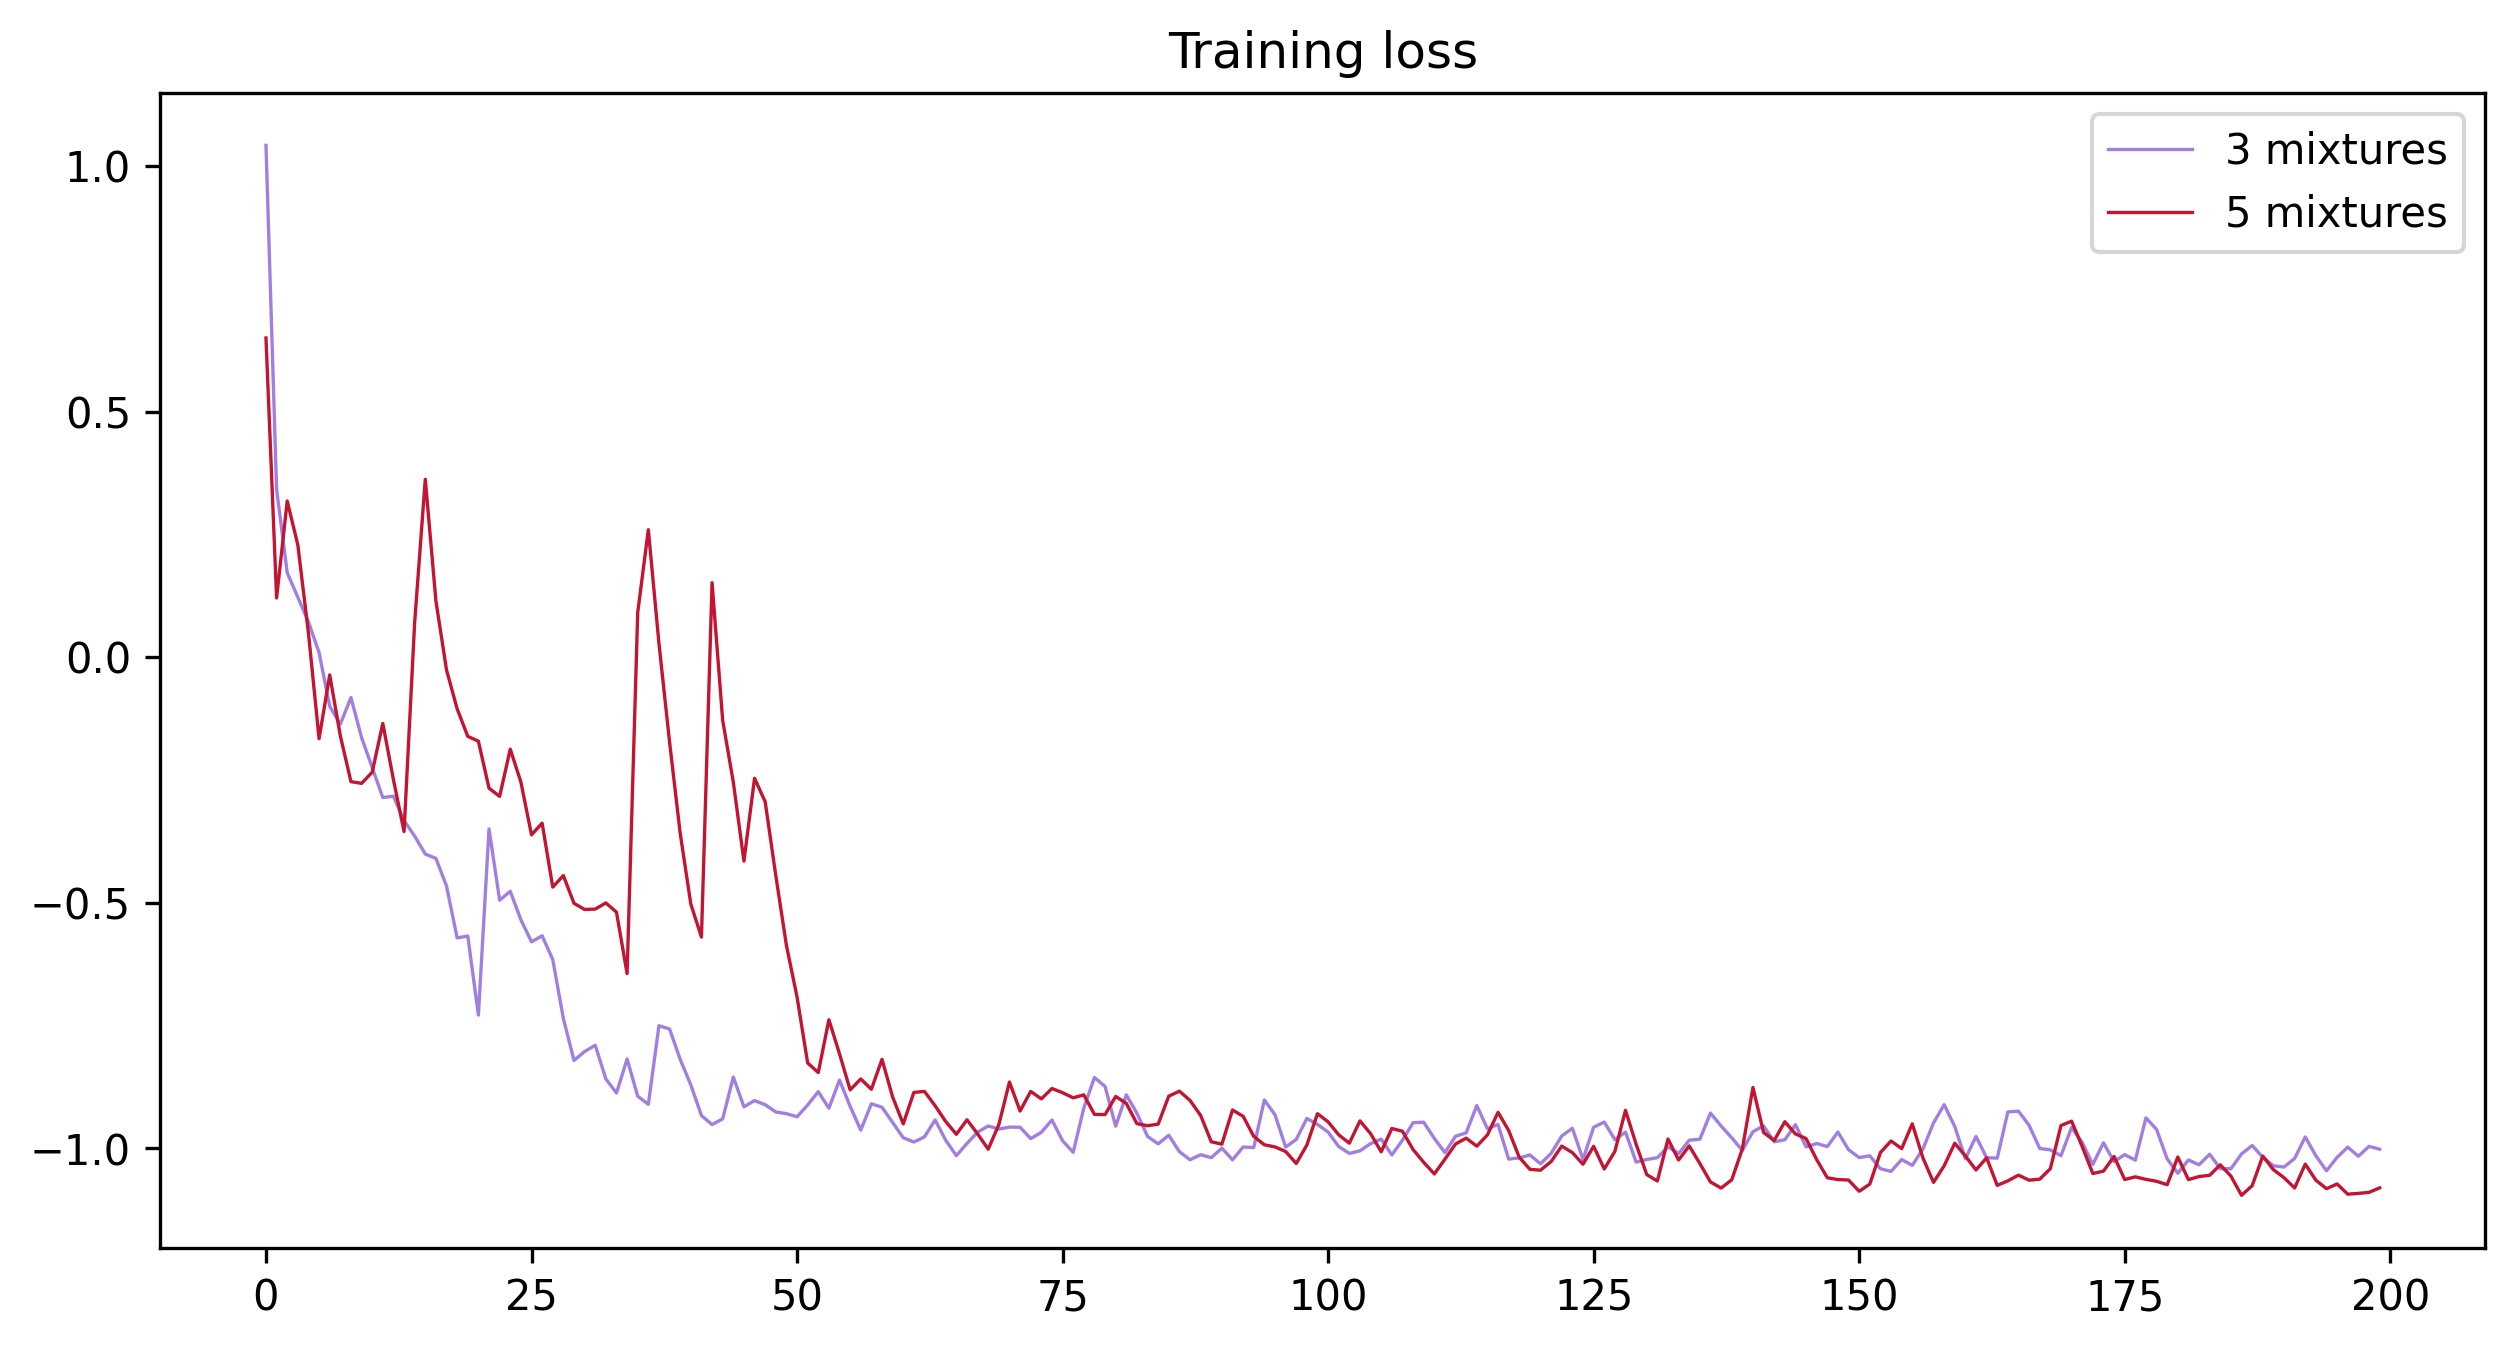

In [8]:
plt.figure(figsize=(10, 5), dpi=300)

plt.plot(train_losses_adam, label="3 mixtures", linewidth=0.8, color="#a17fe0")
# plt.plot(train_losses_bfgs, label="BFGS", linewidth=0.8)
plt.plot(train_losses_5, label="5 mixtures", linewidth=0.8, color="#c31432")
plt.legend()
plt.title("Training loss")
plt.show()

In [9]:
def get_max_mu(x, model):
    mu, _, pi = model(x)
    indices = torch.arange(x.shape[0])
    mu = mu[indices, pi.argmax(dim=1)].detach().cpu()
    return mu

In [10]:
x = sinus_test_dataset.x.unsqueeze(1).to(device)
y = sinus_test_dataset.y.unsqueeze(1).to(device)

mu_adam, sigma_adam, pi_adam = mdn_model_adam(x)
mu_5, sigma_5, pi_5 = mdn_model_5(x)
# mu_bfgs, sigma_bfgs, pi_bfgs = mdn_model_bfgs(x)

In [11]:
mu_adam = mu_adam.detach().cpu()
sigma_adam = sigma_adam.detach().cpu()
pi_adam = pi_adam.detach().cpu()

mu_5 = mu_5.detach().cpu()
sigma_5 = sigma_5.detach().cpu()
pi_5 = pi_5.detach().cpu()

In [12]:
mean_mu_adam = torch.mean(mu_adam, dim=1)
mean_mu_5 = torch.mean(mu_5, dim=1)

In [13]:
# indices = torch.arange(x.shape[0])

# max_mu_idx_adam = torch.argmax(pi_adam, dim=1)
# max_mu_idx_bfgs = torch.argmax(pi_bfgs, dim=1)

# max_mu_adam = mu_adam[indices, max_mu_idx_adam]
# max_mu_bfgs = mu_bfgs[indices, max_mu_idx_bfgs]

max_mu_adam = get_max_mu(x, mdn_model_adam)
# max_mu_bfgs = get_max_mu(x, mdn_model_bfgs)
max_mu_5 = get_max_mu(x, mdn_model_5)

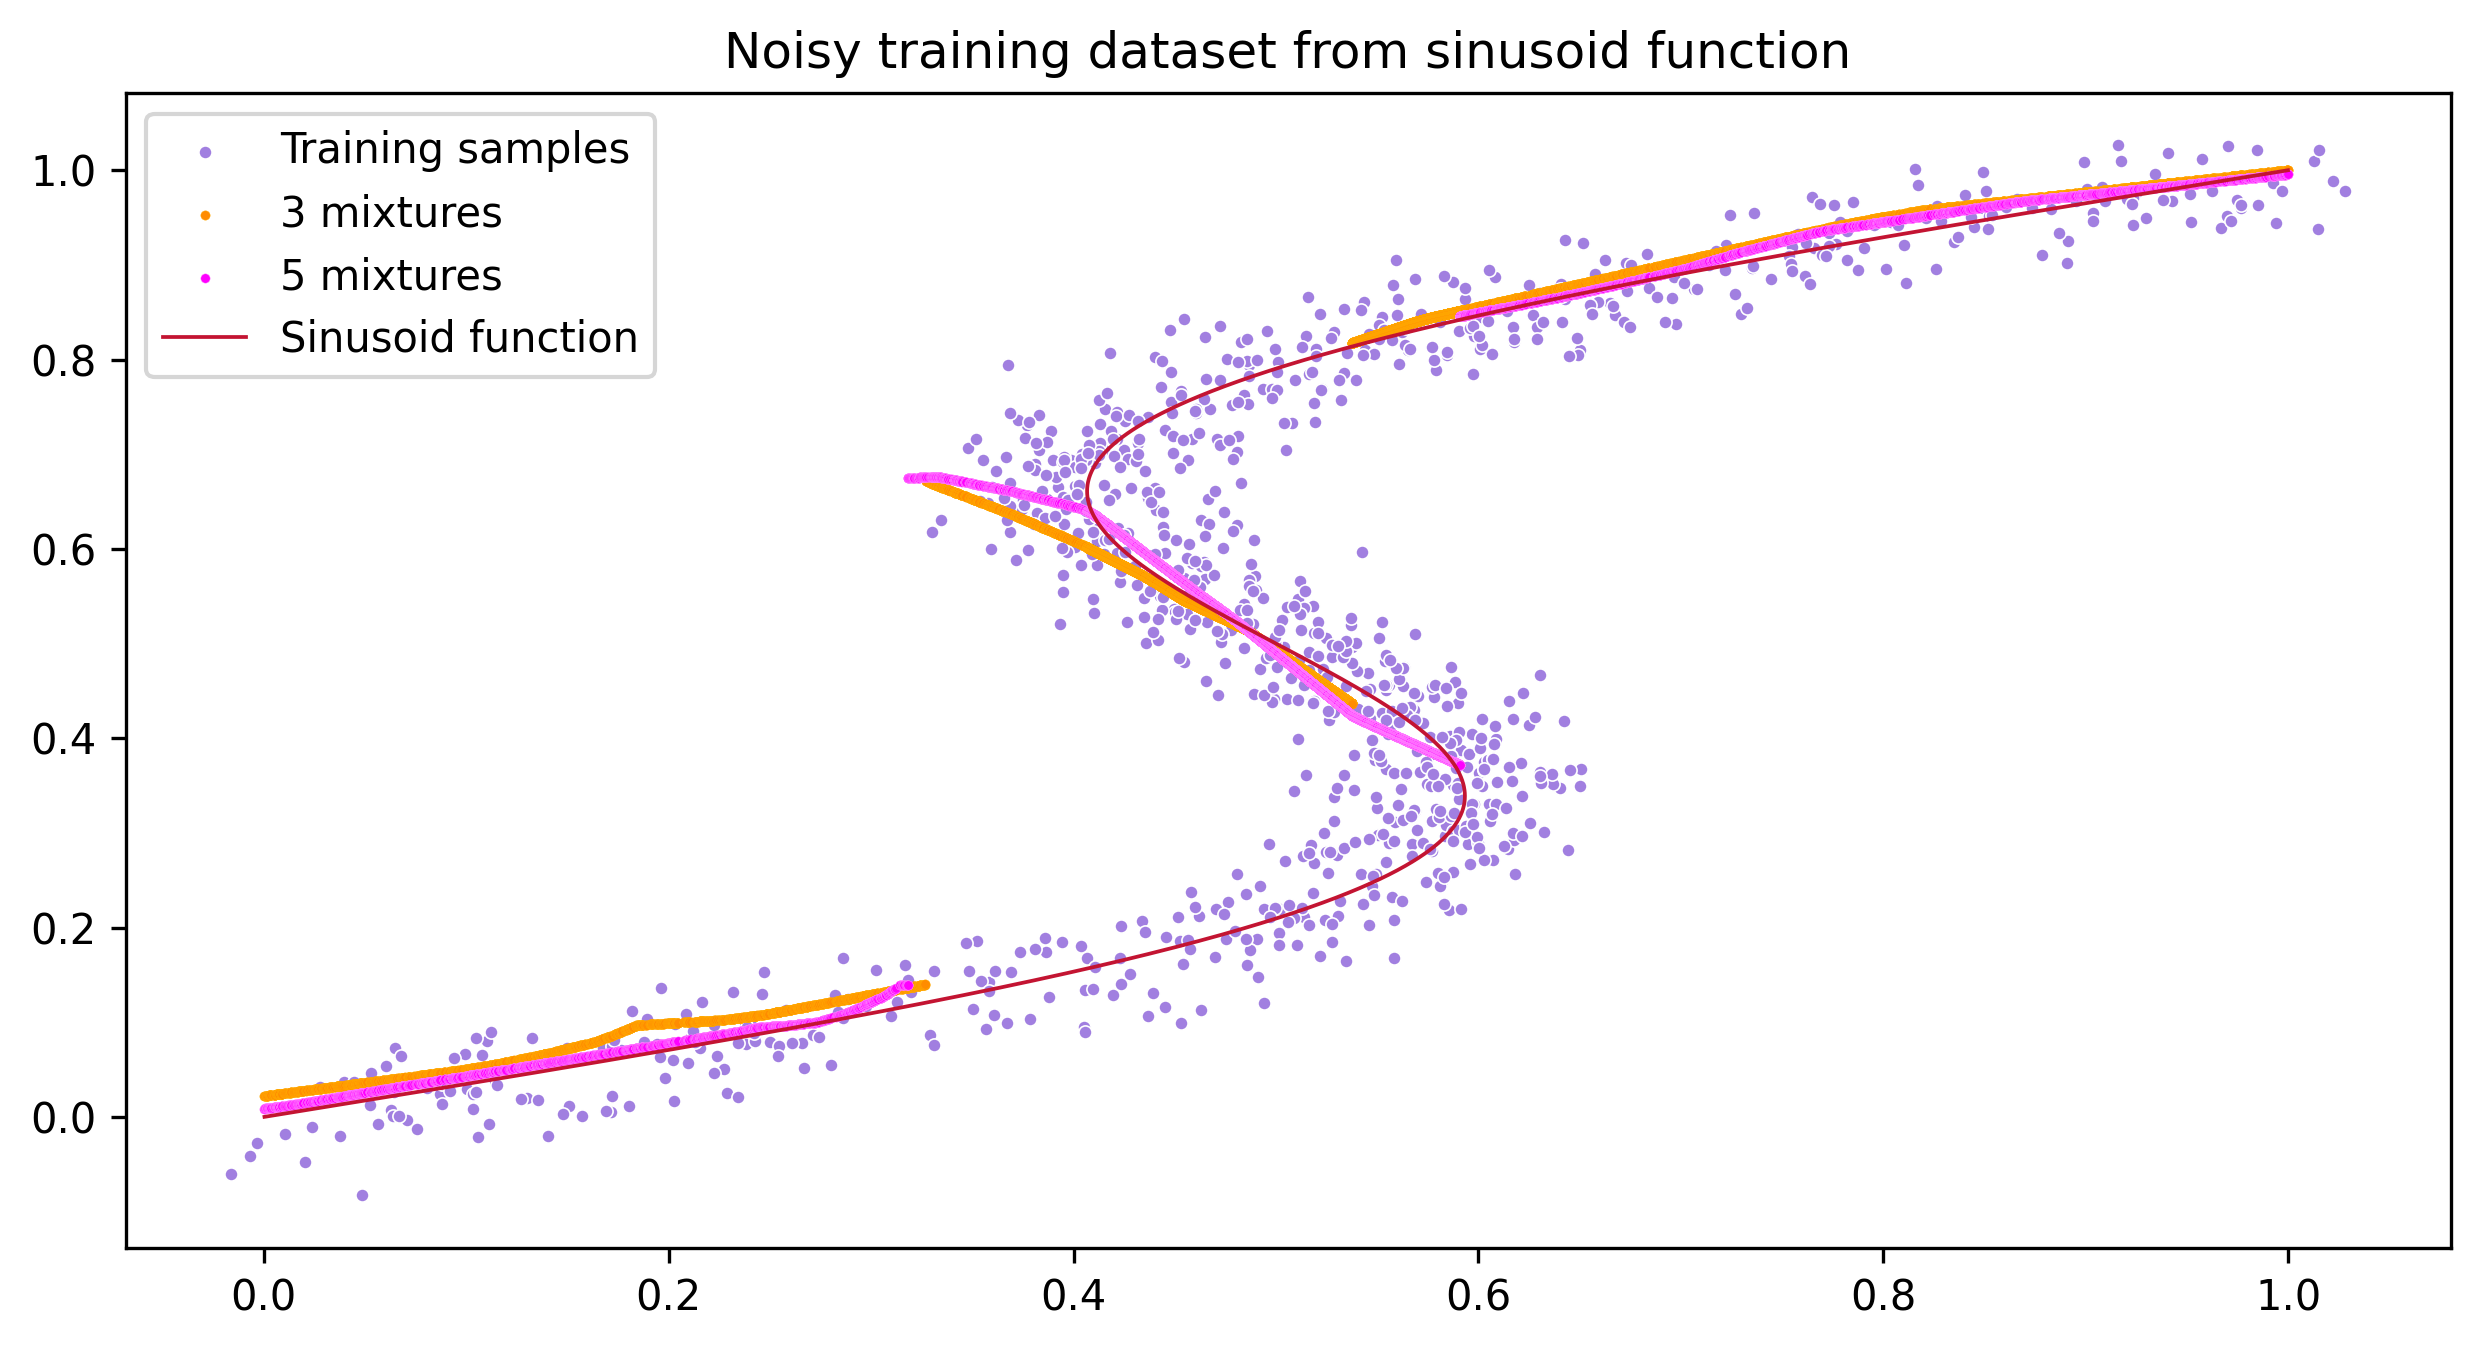

In [14]:
x = x.detach().cpu()
y = y.detach().cpu()

plt.figure(figsize=(10, 5), dpi=300)
plt.scatter(
    sinus_train_dataset.x,
    sinus_train_dataset.y,
    s=10,
    label="Training samples",
    edgecolors="white",
    color="#a17fe0",
    linewidths=0.4,
)

plt.scatter(
    x,
    max_mu_adam,
    label="3 mixtures",
    s=5,
    edgecolors="#ffae00",
    color="#FF8C00",
    linewidths=0.1,
)
# plt.scatter(x, max_mu_bfgs, label="BFGS", s=5, edgecolors="#93ffa3", color="#82e18a", linewidths=0.1)
plt.scatter(
    x,
    max_mu_5,
    label="5 mixtures",
    s=5,
    edgecolors="#ff93ff",
    color="#ff00ff",
    linewidths=0.1,
)

plt.plot(sinusoid(x), x, label="Sinusoid function", color="#c31432", linewidth=0.9)
plt.legend()
plt.title("Noisy training dataset from sinusoid function")
plt.show()

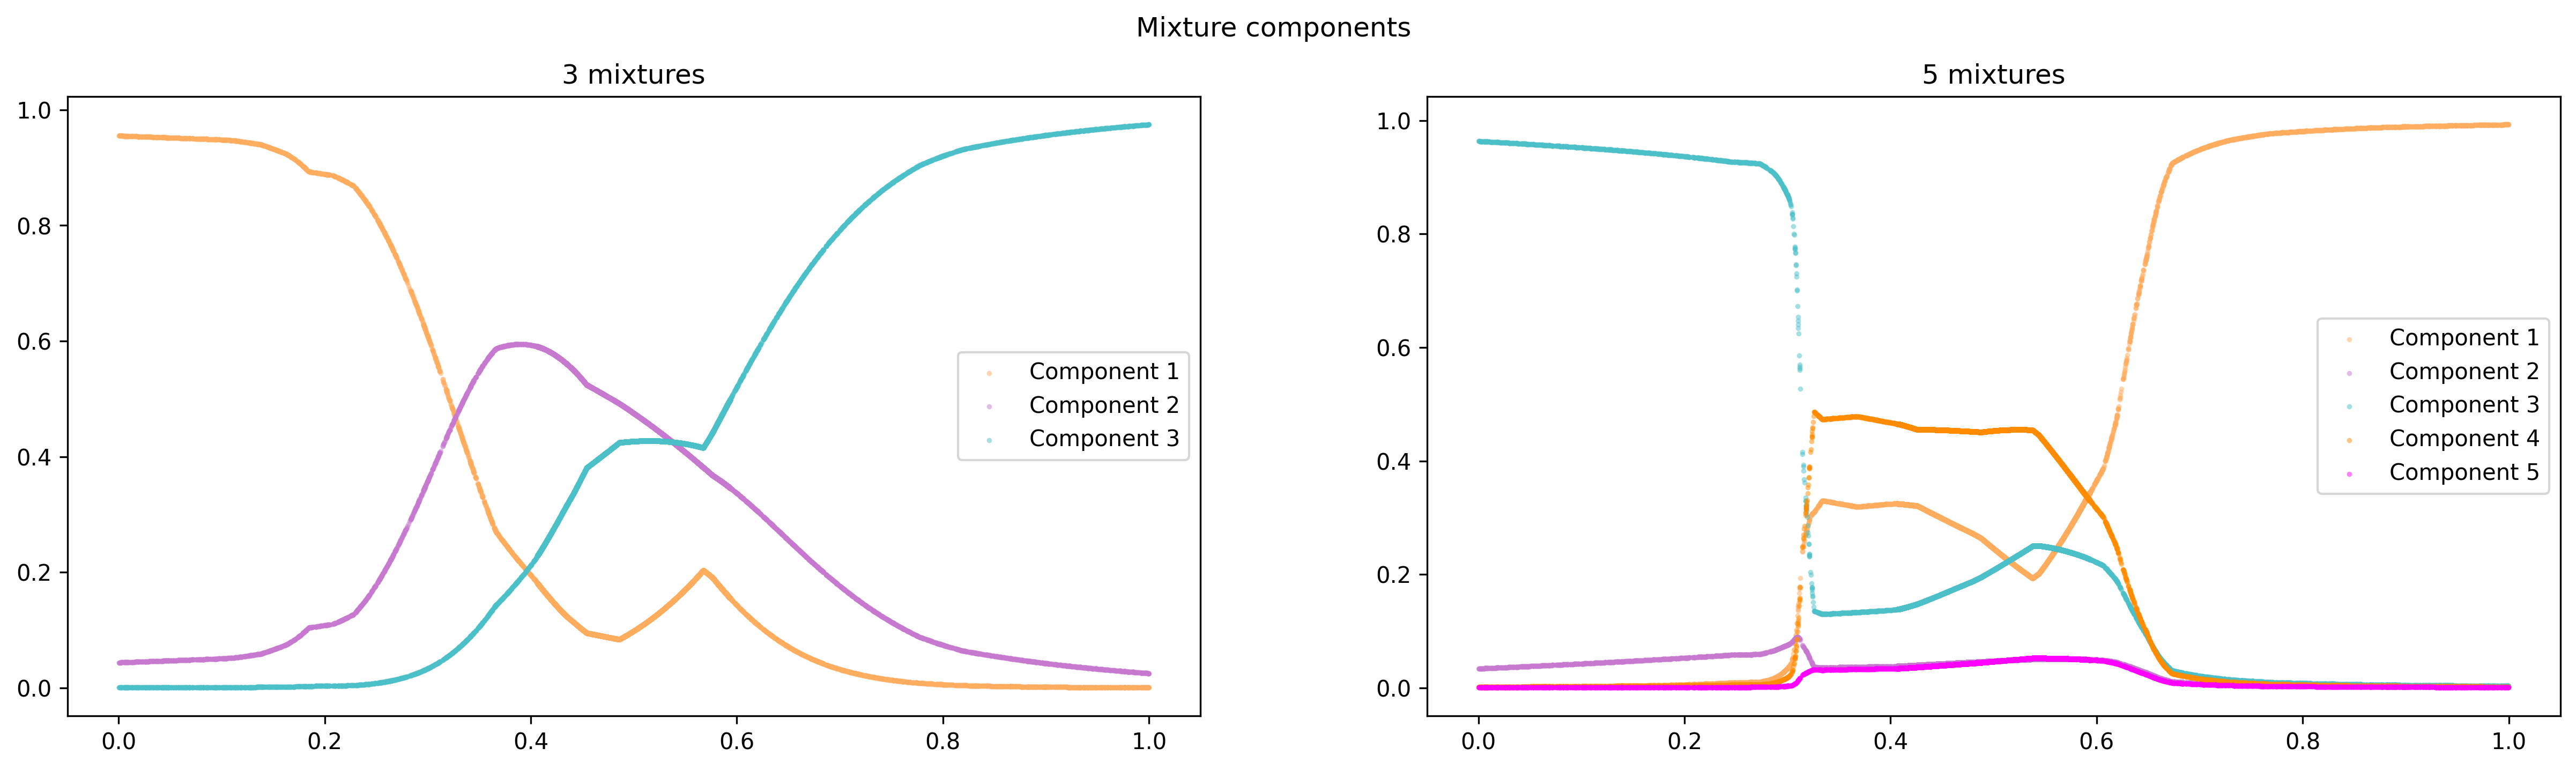

In [22]:
x = x.detach().cpu()
y = y.detach().cpu()

plt.figure(figsize=(20, 5), dpi=300)
plt.suptitle("Mixture components")

plt.subplot(1, 2, 1)
colors = ["#FEAC5E", "#C779D0", "#4BC0C8"]
for i, pi in enumerate(pi_adam.T):
    plt.scatter(
        x,
        pi,
        s=5,
        color=colors[i],
        linewidths=0.05,
        alpha=0.5,
        label=f"Component {i+1}",
    )

plt.title("3 mixtures")
plt.legend()

plt.subplot(1, 2, 2)
colors = ["#FEAC5E", "#C779D0", "#4BC0C8", "#FF8C00", "#ff00ff"]
for i, pi in enumerate(pi_5.T):
    plt.scatter(
        x,
        pi,
        s=5,
        color=colors[i],
        linewidths=0.05,
        alpha=0.5,
        label=f"Component {i+1}",
    )

plt.title("5 mixtures")
plt.legend()

Text(0.5, 1.0, 'Adam 5 mixtures')

<Figure size 3000x1500 with 0 Axes>

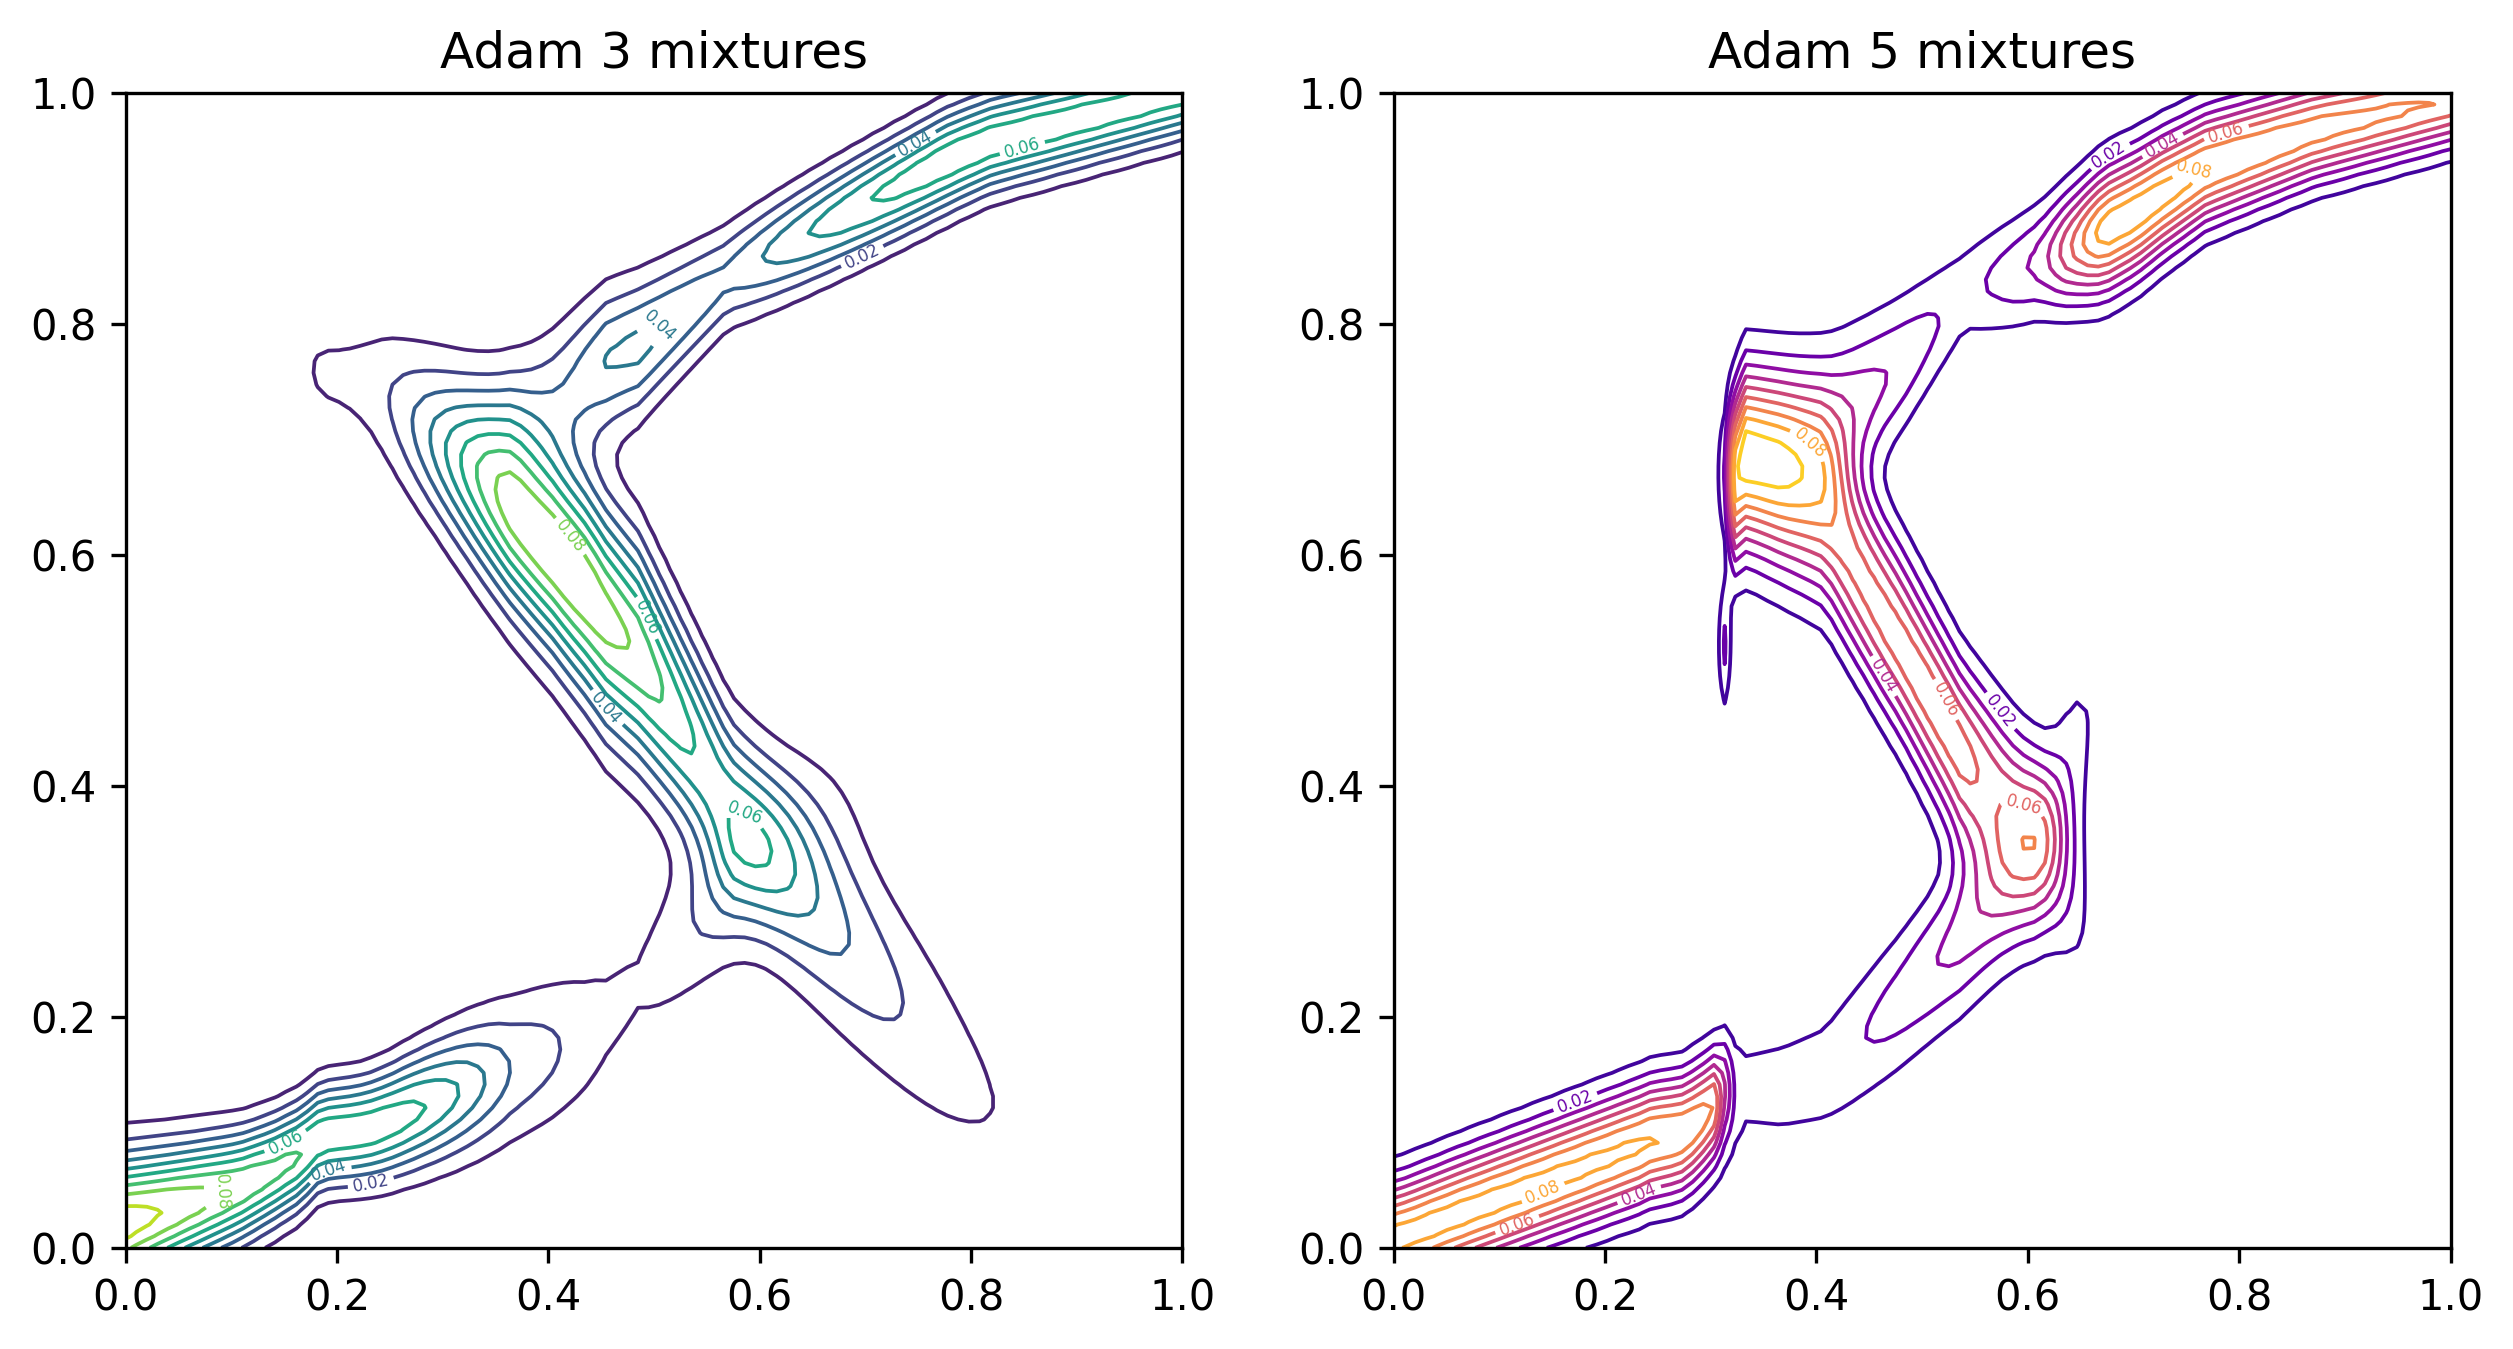

In [19]:
X_dim, Y_dim = 100, 100

X, Y = np.meshgrid(np.linspace(0, 1, X_dim), np.linspace(0, 1, Y_dim))

X_flat = X.flatten()
Y_flat = Y.flatten()


def contour(X, Y, model):
    X = torch.from_numpy(X).float().to(device)
    Y = torch.from_numpy(Y).float().to(device)

    mu, sigma, pi = model(X.T.unsqueeze(1))
    Y = Y.unsqueeze(1)
    mu = mu.squeeze(2)

    exponent = -1 / 2 * ((Y - mu) / sigma) ** 2
    normalizer = torch.sqrt(2 * torch.pi * sigma**2) + 1e-10
    normal_distribution = normalizer * torch.exp(exponent)

    sum_pi_normal = torch.sum(pi * normal_distribution, dim=1)

    return sum_pi_normal.detach().cpu().numpy()


Z_adam = contour(X_flat, Y_flat, mdn_model_adam)
Z_adam = Z_adam.reshape(X_dim, Y_dim)

# Z_bfgs = contour(X_flat, Y_flat, mdn_model_bfgs)
# Z_bfgs = Z_bfgs.reshape(X_dim, Y_dim)

Z_5 = contour(X_flat, Y_flat, mdn_model_5)
Z_5 = Z_5.reshape(X_dim, Y_dim)

plt.figure(figsize=(10, 5), dpi=300)

# Set theme to dark
plt.style.use("dark_background")

# Set theme to light
plt.style.use("default")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
# Add margins
# fig.subplots_adjust(left=0.5, right=0.9, bottom=0.5, top=0.9)
ax1.set_xmargin(1)
ax1.autoscale_view()
ax2.set_xmargin(2)
ax2.autoscale_view()


CS = ax1.contour(X, Y, Z_adam, cmap="viridis", linewidths=0.9, levels=10)
ax1.clabel(CS, inline=1, fontsize=4, levels=CS.levels[::2])
ax1.set_title("Adam 3 mixtures")

CS = ax2.contour(X, Y, Z_5, cmap="plasma", linewidths=0.9, levels=10)
ax2.clabel(CS, inline=1, fontsize=4, levels=CS.levels[::2])
ax2.set_title("Adam 5 mixtures")
# Set ticks invisible

# ax1.axis("off")
# ax2.axis("off")

# plt.setp(ax1.get_xticklabels(), visible=False)
# plt.setp(ax2.get_xticklabels(), visible=False)
# plt.setp(ax1.get_yticklabels(), visible=False)
# plt.setp(ax2.get_yticklabels(), visible=False)